In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/26385
# 标题：基于遗传算法挖掘因子2

import numpy as np
import pandas as pd
import graphviz
from scipy.stats import rankdata
import pickle
import scipy.stats as stats
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

In [2]:
fields = ['open', 'high', 'low', 'avg', 'pre_close', 'close','volume']
length = []

total_data = pd.read_csv('C:/Users/Dell/Desktop/金工研报/stock_data.csv')
total_data.index = total_data.date
total_data = total_data.iloc[:,1:]

#total_data = total_data.iloc[:80000,:]

stock_list = total_data.stock_code.values.tolist()

length =  []
num = 1
for i in range(len(stock_list)-1):
    if stock_list[i+1] == stock_list[i]:
        if i == len(stock_list)-2:
            length.append(num)
            break
        num+=1
    else:
        
        length.append(num)
        num = 1
        
# ------------------------------       
target = total_data['pct10'].values

data = total_data[fields]
data['3'] = 3
data['5'] = 5
data['6']=6
data['8'] = 8
data['10'] = 10
data['12'] = 12
data['15'] = 15
data['20']=20
fields = fields + ['3','5','6','8','10','12','15','20']

X_train = np.nan_to_num(data[:].values)
#X_test = data[-test_num:]
y_train = np.nan_to_num(target)
del data
del target

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
init_function = ['add', 'sub', 'mul', 'div','sqrt', 'log','inv','sin','max','min']

import scipy.stats as stats


def _my_metric(y, y_pred, w):
    x1 = pd.Series(y.flatten() )
    x2 = pd.Series(y_pred.flatten()) 
    df = pd.concat([x1,x2],axis=1)
    df.columns = ['y','y_pred']
    df.sort_values(by = 'y_pred',ascending = True,inplace = True)
    num = int(len(df)*0.1)
    #df.fillna(0, inplace=True)
    
    y_high = df["y"][-num:]
    y_low = df["y"][:num]
    #value = y_high.sum() - y_low.sum()
    value = y_high.mean()/y_low.mean()
    return value

my_metric = make_fitness(function=_my_metric, greater_is_better=True)

In [4]:
def _rolling_rank(data):
    value = rankdata(data)[-1]
    
    return value

def _rolling_prod(data):
    
    return np.prod(data)

def _cube(data):
    return np.square(data)*data

def _square(data):
    return np.square(data)





In [5]:
def _delta(data):
    value = np.diff(data.flatten())
    value = np.append(0, value)

    return value

def _delay(data):
    period=1
    value = pd.Series(data.flatten()).shift(1)
    value = np.nan_to_num(value)
    
    return value


'''
def _scale(data):
    k=1
    data = pd.Series(data.flatten())
    value = data.mul(1).div(np.abs(data).sum())
    value = np.nan_to_num(value)
    
    return value
'''

        
        
def _corr(data1,data2,n):
    
    with np.errstate(divide='ignore', invalid='ignore'):

            
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]

                x1 = pd.Series(data1.flatten())
                x2 = pd.Series(data2.flatten())

                df = pd.concat([x1,x2],axis=1)
                temp = pd.Series()
                for i in range(len(df)):
                    if i<=window-2:
                        temp[str(i)] = np.nan
                    else:
                        df2 = df.iloc[i-window+1:i,:]
                        temp[str(i)] = df2.corr('spearman').iloc[1,0]
                return np.nan_to_num(temp)
            else:
                return np.zeros(data1.shape[0])
            
        except:
            return np.zeros(data1.shape[0])



def _ts_sum(data,n):

    with np.errstate(divide='ignore', invalid='ignore'):

        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
    
                value = np.array(pd.Series(data.flatten()).rolling(window).sum().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])

        except:
            return np.zeros(data.shape[0])
        


def _sma(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):

        try:    
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
                
                value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
              
        except:
            return np.zeros(data.shape[0])

def _stddev(data,n):   
    with np.errstate(divide='ignore', invalid='ignore'):

        try:    
            if n[0] == n[1] and n[1] ==n[2]:
                window  = int(np.mean(n))
                
                value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
                
        except:
            return np.zeros(data.shape[0])

def _ts_rank(data,n):
    
    with np.errstate(divide='ignore', invalid='ignore'):

        try:
            if n[0] == n[1] and n[1] ==n[2]:        
                value = np.array(pd.Series(data.flatten()).rolling(window).apply(_rolling_rank).tolist())
                value = np.nan_to_num(value)

                return value
            else:
                return np.zeros(data.shape[0])    
        except:
            return np.zeros(data.shape[0])


ts_rank = make_function(function=_ts_rank, name='ts_rank', arity=2)



def _ts_argmin(data,n):

    try:
        if n[0] == n[1] and n[1] ==n[2]:
            window=n[0]
            value = pd.Series(data.flatten()).rolling(window).apply(np.argmin) + 1 
            value = np.nan_to_num(value)
            return value
        else:
            return np.zeros(data.shape[0])  
    except:
        return np.zeros(data.shape[0])


def _ts_argmax(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window=n[0]
                value = pd.Series(data.flatten()).rolling(window).apply(np.argmax) + 1 
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])
        
def _ts_min(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
                #window  = int(np.mean(n))
                value = np.array(pd.Series(data.flatten()).rolling(window).min().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
                
        except:
            return np.zeros(data.shape[0])  
        
def _ts_max(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
    
                value = np.array(pd.Series(data.flatten()).rolling(window).max().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
         
                
        except:
            return np.zeros(data.shape[0])  
        
def _ts_argmaxmin(data,n):
    return _ts_argmax(data,n) - _ts_argmin(data,n)


In [6]:
stddev = make_function(function=_stddev, name='stddev', arity=2)
ts_sum = make_function(function=_ts_sum, name='ts_sum', arity=2)

In [7]:
ts_sum = make_function(function=_ts_sum, name='ts_sum', arity=2)
stddev = make_function(function=_stddev, name='stddev', arity=2)

In [8]:
corr = make_function(function=_corr, name='corr', arity=3)#     

In [9]:
#ts_min = make_function(function=_ts_min, name='ts_min', arity=2)

delta = make_function(function=_delta, name='delta', arity=1)
delay = make_function(function=_delay, name='delay', arity=1)
sma = make_function(function=_sma, name='sma', arity=2)

cube = make_function(function=_cube, name='cube', arity=1)
square = make_function(function=_square, name='square', arity=1)

In [10]:
ts_argmaxmin = make_function(function=_ts_argmaxmin, name='ts_argmaxmin', arity=2)

ts_argmax = make_function(function=_ts_argmax, name='ts_argmax', arity=2)
ts_argmin = make_function(function=_ts_argmin, name='ts_argmin', arity=2)

In [11]:
ts_min = make_function(function=_ts_min, name='ts_min', arity=2)
   
ts_max = make_function(function=_ts_max, name='ts_max', arity=2)

In [12]:
user_function = [square,cube,delta, delay, ts_argmax ,sma,stddev, ts_argmin, ts_max,ts_min,ts_sum,ts_rank,ts_argmaxmin,corr 
                 ]


In [25]:
function_set = init_function + user_function
metric = my_metric
population_size = 3000
generations = 3
random_state=5
est_gp = SymbolicTransformer(
                            feature_names=fields, 
                            function_set=function_set,
                            generations=generations,
                            metric=metric,#'spearman'秩相关系数
                            population_size=population_size,
                            tournament_size=30, 
                            random_state=random_state,
                            verbose=2,
                            parsimony_coefficient=0.0001,
                            p_crossover = 0.4,
                            p_subtree_mutation = 0.01,
                            p_hoist_mutation = 0,
                            p_point_mutation = 0.01,
                            p_point_replace = 0.4,
                            n_jobs = 6
                         )
###------------set 训练集的为空值---------
num_set_y_nan = 0
for i in length:
    num_set_y_nan = i + num_set_y_nan
    try:
        y_train[num_set_y_nan] = np.nan
    except:
        break

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  2.9min remaining:  5.9min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  3.0min finished


   0    15.55       -0.0199165        5           8.8728              N/A      5.97m


SymbolicTransformer(const_range=(-1.0, 1.0),
          feature_names=['open', 'high', 'low', 'avg', 'pre_close', 'close', 'volume', '3', '5', '6', '8', '10', '12', '15', '20'],
          function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'inv', 'sin', 'max', 'min', <gplearn.functions._Function object at 0x0000029AFAFAA550>, <gplearn.functions._Function object at 0x0000029AFAFAA470>, <gplearn.functions._Function object at 0x0000029AFAFAA438>, <gplearn.functions._Function object..._Function object at 0x0000029A81FB00F0>, <gplearn.functions._Function object at 0x0000029AFAFAA0F0>],
          generations=3, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', low_memory=False, max_samples=1.0,
          metric=<gplearn.fitness._Fitness object at 0x0000029AF9EE3D68>,
          n_components=10, n_jobs=6, p_crossover=0.4, p_hoist_mutation=0,
          p_point_mutation=0.01, p_point_replace=0.4,
          p_subtree_mutation=0.01, parsimony_coefficient=0.0001,
     

In [26]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict 

,depth,expression,fitness,length
alpha_10,5,"sin(cube(max(mul(cube(close), delay(12)), ts_m...",0.759518,15
alpha_9,2,log(sin(close)),1.01029,3
alpha_8,3,"sin(cube(add(12, close)))",1.014,5
alpha_7,5,"log(sin(square(mul(volume, sub(low, 6)))))",1.03377,8
alpha_6,4,"sin(sub(cube(square(pre_close)), log(volume)))",1.04524,7
alpha_5,5,"sin(sub(ts_max(sma(ts_argmaxmin(15, 3), div(12...",1.1317,16
alpha_4,1,sin(volume),1.33923,2
alpha_3,2,sqrt(sin(volume)),1.66328,3
alpha_2,2,"max(sqrt(high), delay(20))",5.88754,5
alpha_1,3,"square(delta(div(5, high)))",8.8723,5


square(delta(div(5, high)))
fitness: 8.87229947893117, depth: 3, length: 5


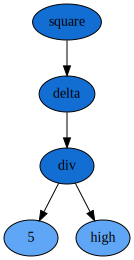

In [27]:
def alpha_factor_graph(num):
    # 打印指定num的表达式图

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

graph1 = alpha_factor_graph(1)
graph1

In [29]:
import jqdatasdk as jq
import jqfactor_analyzer as ja

jq.auth('账号', 'password')


stock_list = jq.get_index_stocks('000906.XSHG')

auth success 


In [31]:
data = jq.get_price(stock_list, end_date='2020-03-20', 
frequency='daily', fields=['high'], count=30)
df1 = 12/data['high']


In [35]:
np.square()

,000001.XSHE,000002.XSHE,000006.XSHE,000008.XSHE,000009.XSHE,000012.XSHE,000021.XSHE,000025.XSHE,000027.XSHE,000028.XSHE,...,603877.XSHG,603882.XSHG,603883.XSHG,603885.XSHG,603888.XSHG,603899.XSHG,603939.XSHG,603983.XSHG,603986.XSHG,603993.XSHG
2020-02-10,0.825877,0.415512,2.608696,3.809524,1.655172,2.758621,0.790514,0.622084,2.169982,0.214286,...,0.759494,0.208333,0.156965,0.990917,0.433526,0.252898,0.132465,0.177357,0.040553,2.912621
2020-02-11,0.803213,0.406366,2.531646,3.809524,1.574803,2.569593,0.793651,0.618238,2.154399,0.235294,...,0.733945,0.204848,0.160729,0.957702,0.406780,0.243408,0.133615,0.176341,0.041479,2.764977
2020-02-12,0.809717,0.409556,2.553191,3.821656,1.619433,2.479339,0.740741,0.627287,2.146691,0.240288,...,0.750469,0.204778,0.161312,0.978793,0.426591,0.239473,0.135272,0.174292,0.040605,2.547771
2020-02-13,0.806452,0.390244,2.510460,3.785489,1.639344,2.321083,0.686499,0.625000,2.150538,0.243902,...,0.751409,0.207433,0.164948,0.973236,0.429338,0.240048,0.137315,0.176835,0.037403,2.316602
2020-02-14,0.792602,0.389610,2.531646,3.846154,1.668985,2.439024,0.690846,0.628272,2.173913,0.247934,...,0.781759,0.209424,0.168256,0.982801,0.438757,0.246002,0.138568,0.175439,0.036923,2.173913


In [39]:
def alpha2(stock_list,date1,N):
    data = jq.get_price(stock_list, end_date=date1, 
    frequency='daily', fields=['high'], count=N)
    df1 = 12/data['high']
    df2 = pd.DataFrame(np.diff(df1,axis=0),index = df1.iloc[1:].index,columns = df1.columns)
    
    return df2*df2

In [40]:
factor = alpha2(stock_list,'2020-03-20',500)

In [41]:
factor

,000001.XSHE,000002.XSHE,000006.XSHE,000008.XSHE,000009.XSHE,000012.XSHE,000021.XSHE,000025.XSHE,000027.XSHE,000028.XSHE,...,603877.XSHG,603882.XSHG,603883.XSHG,603885.XSHG,603888.XSHG,603899.XSHG,603939.XSHG,603983.XSHG,603986.XSHG,603993.XSHG
2018-03-05,1.208742e-05,2.542861e-05,0.000000,0.000004,0.001801,0.000000,0.000039,1.569250e-03,0.000539,0.000000e+00,...,1.147143e-06,9.974230e-05,4.267066e-06,0.000095,4.104640e-04,1.842084e-05,1.546774e-05,NaN,1.942948e-05,0.002415
2018-03-06,6.718743e-06,4.260619e-05,0.000000,0.000040,0.001428,0.000772,0.000341,6.151493e-05,0.009715,1.596815e-05,...,5.903190e-07,5.384089e-04,1.679199e-04,0.000005,2.905040e-05,1.026075e-04,1.966246e-04,NaN,8.366393e-05,0.000023
2018-03-07,3.780271e-04,5.433610e-06,0.000000,0.000368,0.000086,0.000327,0.000236,1.565525e-03,0.000049,0.000000e+00,...,9.344607e-06,7.959337e-05,9.648465e-10,0.000008,8.025469e-05,1.742859e-05,3.617641e-07,NaN,1.520980e-06,0.000010
2018-03-08,2.562330e-04,4.344323e-06,0.020623,0.000075,0.000021,0.000702,0.000060,7.465560e-04,0.003749,1.604239e-06,...,5.237565e-06,0.000000e+00,7.596177e-06,0.000320,1.494992e-04,5.637934e-05,2.498938e-09,NaN,1.216173e-06,0.003207
2018-03-09,1.816500e-05,3.850713e-06,0.003207,0.000043,0.002449,0.000422,0.000331,8.341327e-04,0.005156,3.019506e-05,...,1.750511e-04,5.136827e-05,1.012793e-04,0.000008,1.009348e-04,5.194445e-05,3.827895e-05,NaN,1.216173e-06,0.000249
2018-03-12,6.517363e-06,6.654767e-06,0.004989,0.000019,0.000682,0.000078,0.000367,1.700539e-08,0.000000,3.930845e-06,...,7.647126e-05,5.735457e-04,3.823147e-06,0.000154,4.778198e-05,8.634693e-05,4.845901e-05,NaN,3.274958e-05,0.006457
2018-03-13,1.804304e-05,9.789173e-05,0.000248,0.000019,0.006232,0.000136,0.000034,3.791144e-06,0.000000,1.391614e-07,...,9.367080e-06,5.150415e-05,2.531509e-08,0.000014,7.904559e-05,9.314679e-06,8.906001e-07,NaN,4.044855e-05,0.003152
2018-03-14,3.270437e-04,1.681621e-06,0.001527,0.000485,0.000410,0.000422,0.000898,2.513977e-04,0.000114,4.648658e-07,...,9.521541e-05,5.150415e-05,2.294695e-07,0.000530,6.509785e-05,1.169136e-04,1.183718e-06,NaN,5.640785e-06,0.000811
2018-03-15,1.774228e-04,3.244494e-06,0.006207,0.000081,0.006469,0.000853,0.000475,2.337297e-05,0.000013,5.702585e-06,...,4.928469e-05,2.434596e-04,1.246992e-05,0.000006,5.227166e-06,1.954972e-05,2.759942e-05,NaN,7.100675e-07,0.000008
2018-03-16,0.000000e+00,8.547966e-06,0.001094,0.000129,0.010135,0.000414,0.000121,1.598074e-05,0.000455,3.245580e-06,...,1.002058e-05,3.969390e-05,0.000000e+00,0.000367,3.351222e-06,1.568044e-05,5.429473e-06,NaN,3.728483e-06,0.001089


分位数统计


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000000e+00,0.000439,0.000002,0.000016,36098,10.037985
2,5.536110e-10,0.002075,0.000016,0.000072,35967,10.001557
3,1.448673e-06,0.005791,0.000048,0.000209,35891,9.980423
4,5.057299e-06,0.012257,0.000108,0.000466,35962,10.000167
5,1.286921e-05,0.020691,0.000207,0.000845,35947,9.995996
6,2.945396e-05,0.033887,0.000368,0.001385,35919,9.988210
7,5.495223e-05,0.056187,0.000642,0.002261,35907,9.984873
8,1.071262e-04,0.091827,0.001152,0.003597,35946,9.995718
9,2.477979e-04,0.173532,0.002378,0.006748,35908,9.985151



-------------------------

收益分析


,period_5,period_10
Ann. alpha,0.086,0.054
beta,1.100,1.237
Mean Period Wise Return Top Quantile (bps),3.145,2.057
Mean Period Wise Return Bottom Quantile (bps),2.959,1.768
Mean Period Wise Spread (bps),-0.433,-0.435


<Figure size 432x288 with 0 Axes>

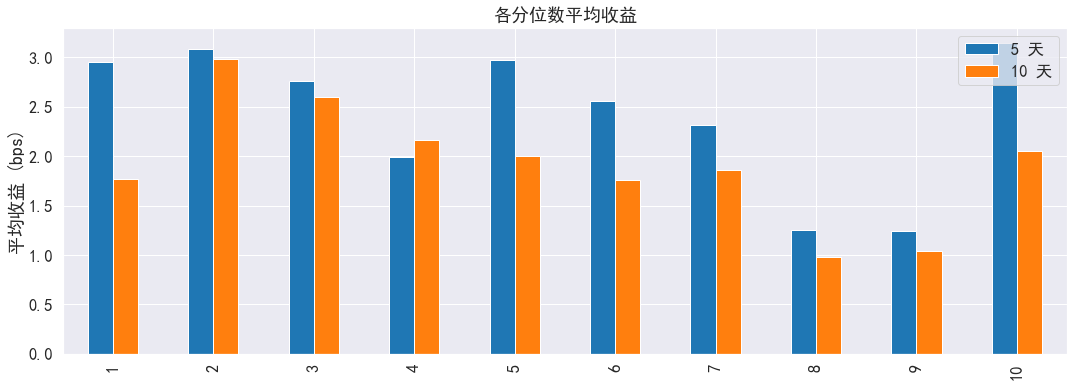

<Figure size 432x288 with 0 Axes>

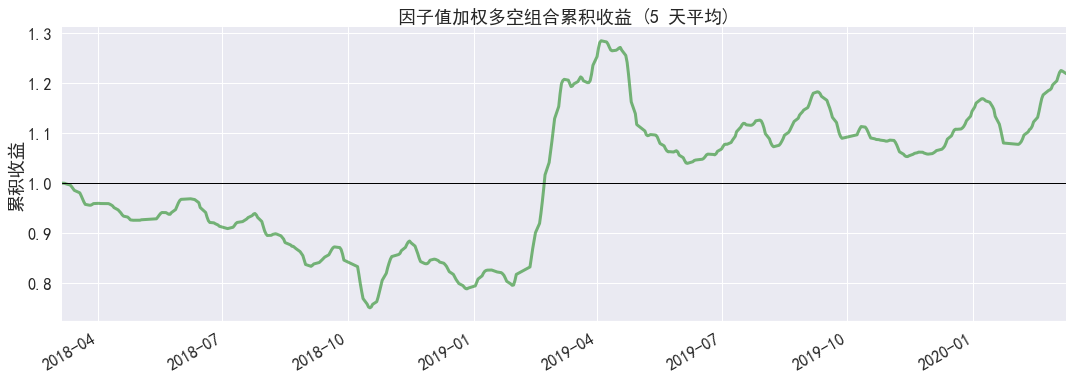

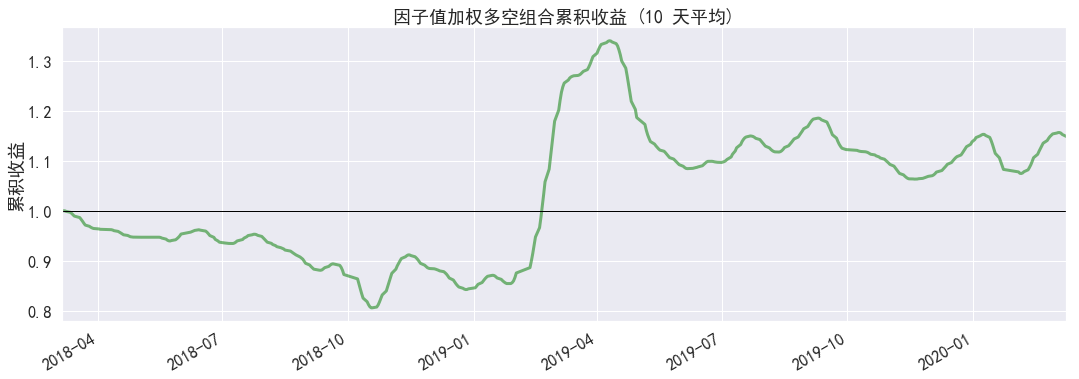

<Figure size 432x288 with 0 Axes>

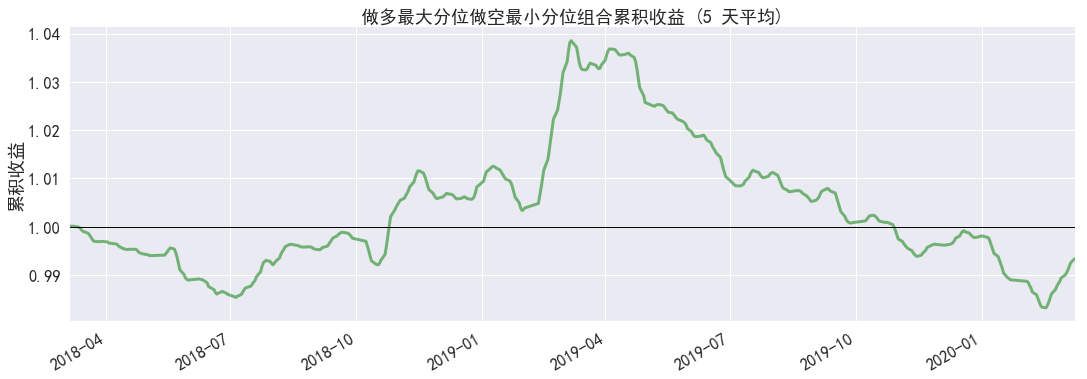

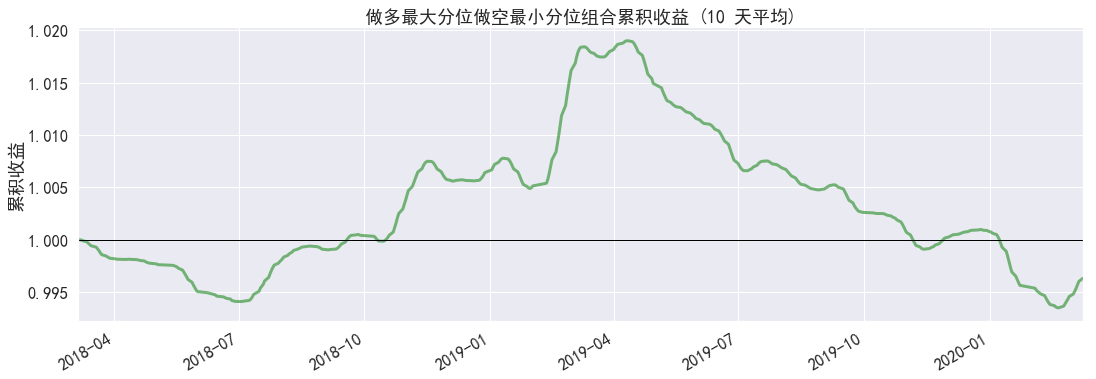

<Figure size 432x288 with 0 Axes>

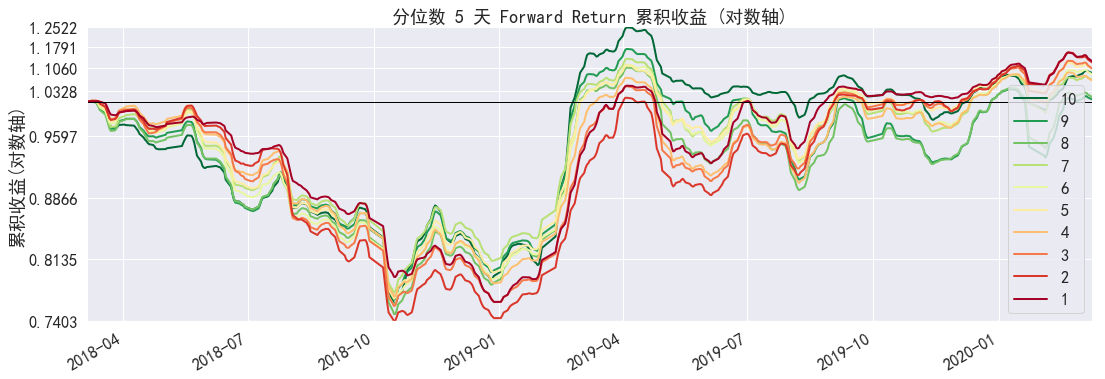

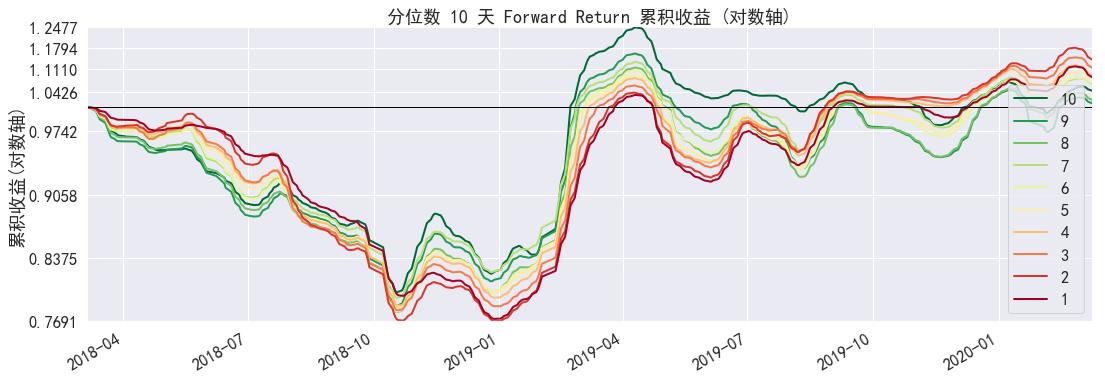

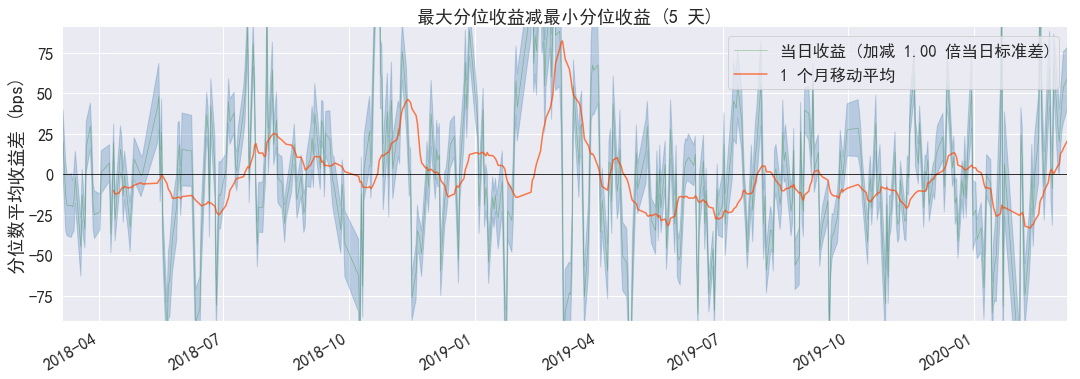

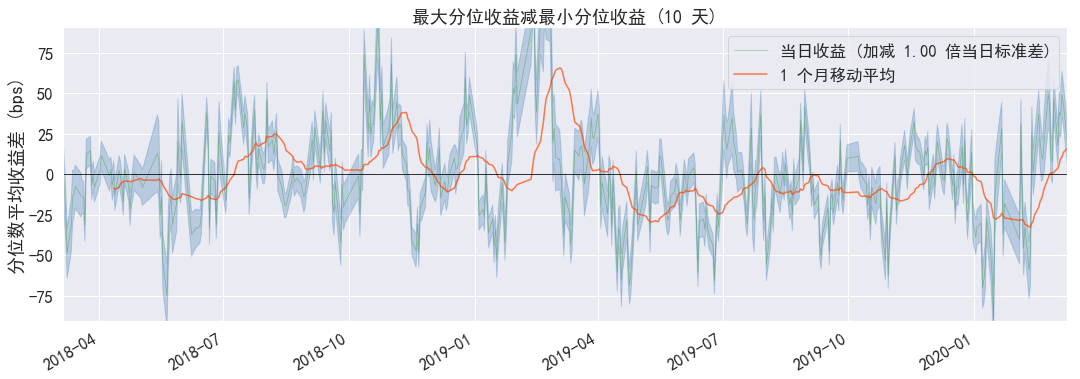

<Figure size 432x288 with 0 Axes>

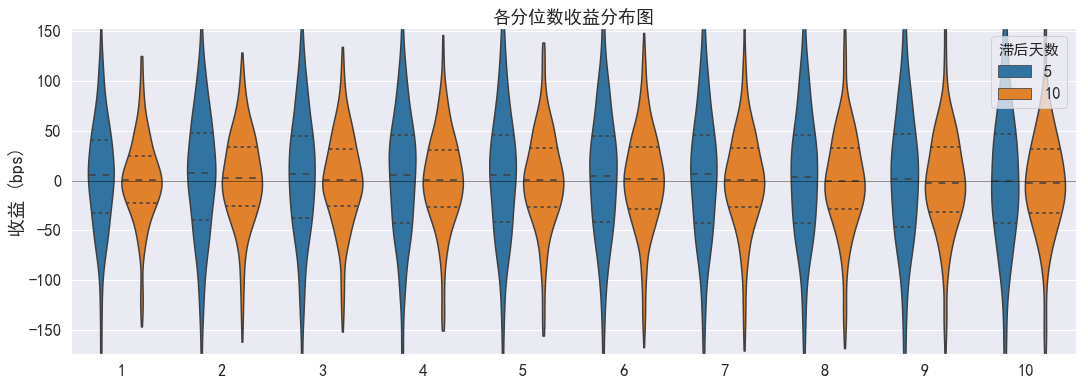


-------------------------

IC 分析


,period_5,period_10
IC Mean,-0.031,-0.035
IC Std.,0.137,0.139
IR,-0.225,-0.253
t-stat(IC),-4.800,-5.416
p-value(IC),0.000,0.000
IC Skew,0.320,0.392
IC Kurtosis,0.057,0.021


<Figure size 432x288 with 0 Axes>

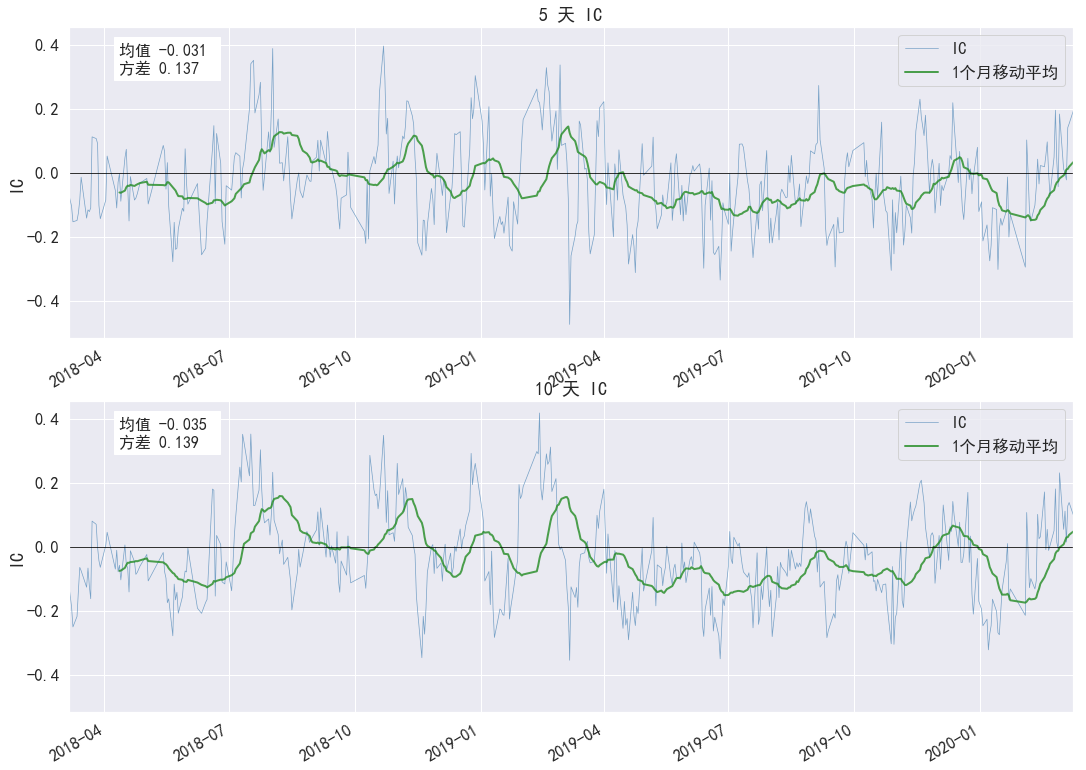

<Figure size 432x288 with 0 Axes>

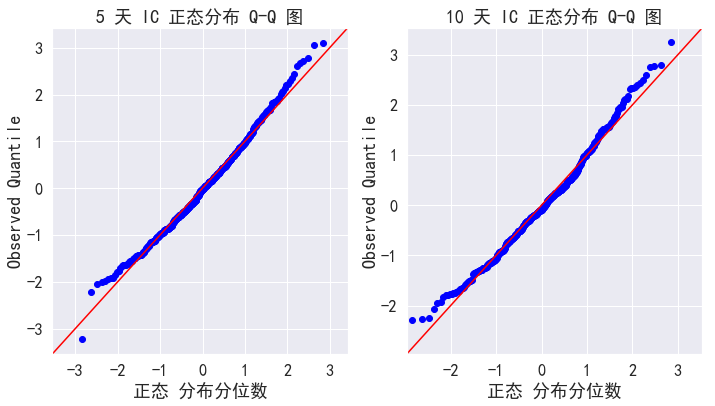

<Figure size 432x288 with 0 Axes>

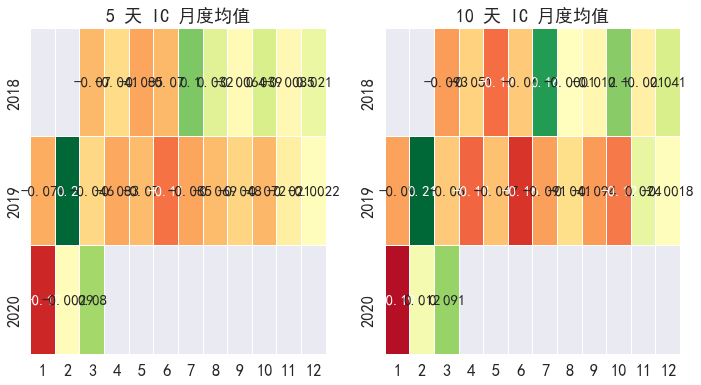


-------------------------

换手率分析


,period_10,period_5
Quantile 1 Mean Turnover,0.745,0.735
Quantile 2 Mean Turnover,0.798,0.801
Quantile 3 Mean Turnover,0.854,0.854
Quantile 4 Mean Turnover,0.870,0.871
Quantile 5 Mean Turnover,0.880,0.880
Quantile 6 Mean Turnover,0.880,0.878
Quantile 7 Mean Turnover,0.874,0.876
Quantile 8 Mean Turnover,0.865,0.866
Quantile 9 Mean Turnover,0.834,0.833
Quantile 10 Mean Turnover,0.702,0.693


,period_5,period_10
Mean Factor Rank Autocorrelation,0.37,0.366


<Figure size 432x288 with 0 Axes>

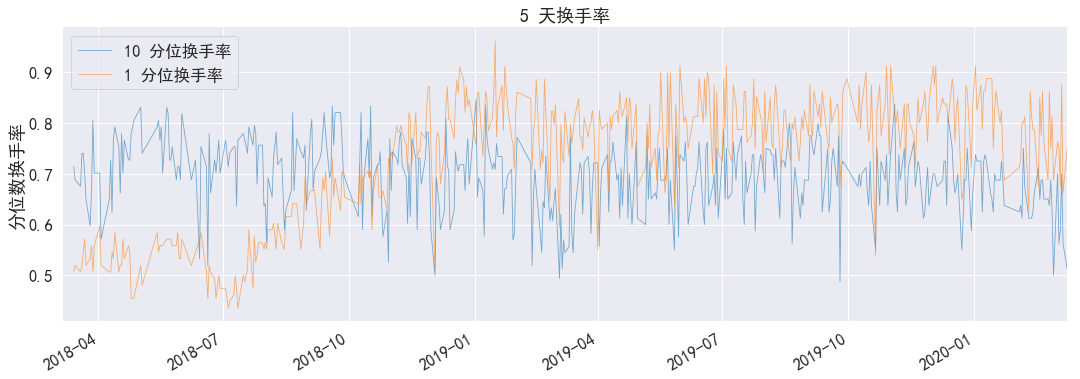

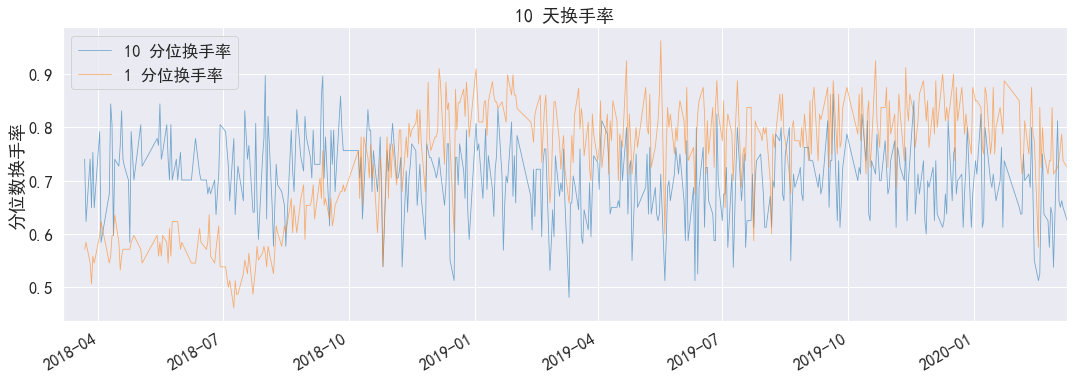

<Figure size 432x288 with 0 Axes>

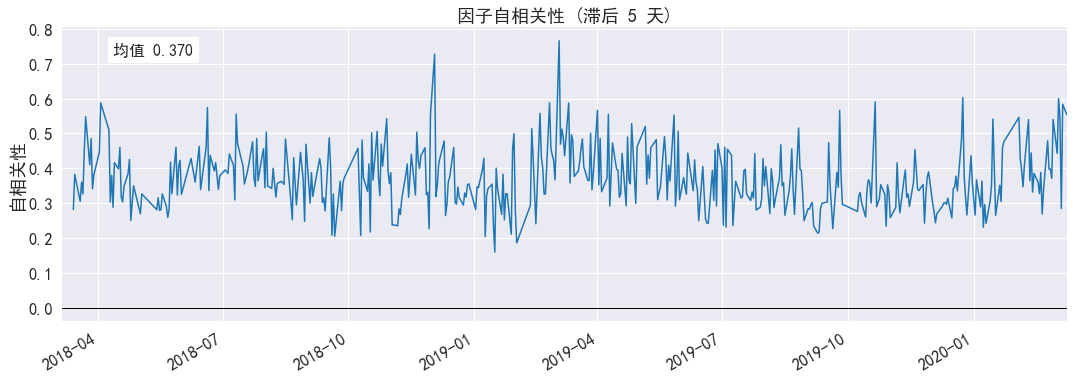

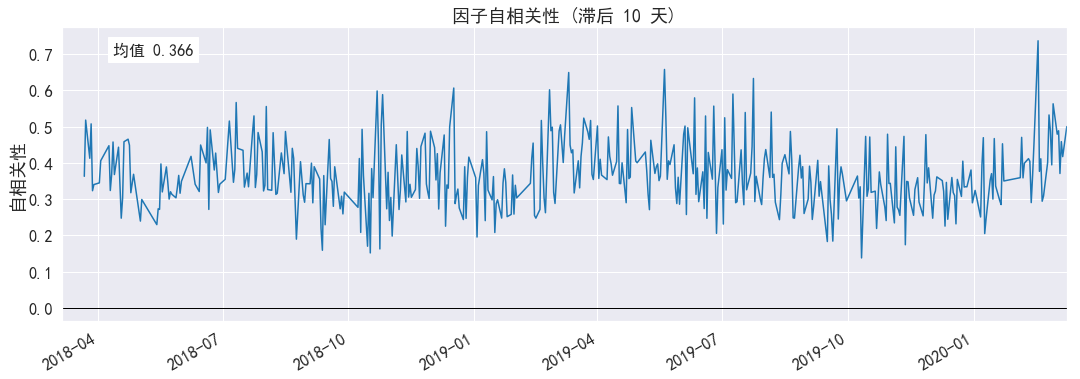


-------------------------



<Figure size 432x288 with 0 Axes>

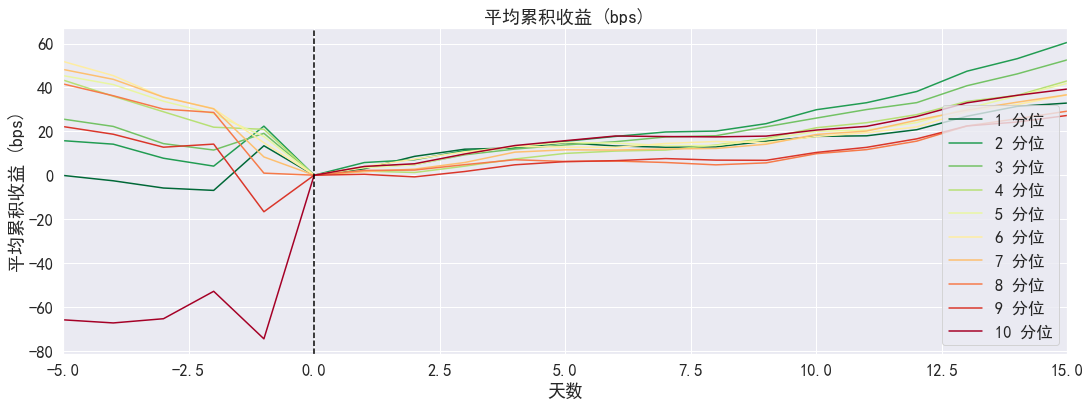

In [43]:
periods=(5, 10)
# 设置分层数量
quantiles=10

far = ja.analyze_factor(factor=factor, 
                        weight_method='avg', 
                        industry='jq_l1', 
                        quantiles=quantiles, 

                        periods=periods,
                        max_loss=0.4)


# 生成统计图表
far.create_full_tear_sheet(
    demeaned=False, group_adjust=False, by_group=False,
    turnover_periods=None, avgretplot=(5, 15), std_bar=False
)

In [ ]:
stock_list = jq.get_index_stocks('000906.XSHG')

def alpha2(stock_list,date1,N):
    data = jq.get_price(stock_list, end_date=date1, 
    frequency='daily', fields=['open','volume'], count=N)
    df1 = data['open'].rank(axis='columns')
    df2 = data['volume'].rank(axis='columns')
    return sigmoid(df1/df2)

alpha2(stock_list,'2020-03-12',5)


factor23 = alpha23(stock_list,'2020-03-12',700)

periods=(5, 10,20)